solafune:夜間光データから土地価格を予測 BaseLine(by mst8823)

https://zenn.dev/mst8823/articles/cd40cb971f702e の写経

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
#from ptitprince import RainCloud

from pandas_profiling import ProfileReport
%matplotlib inline

print(os.getcwd())

/content


In [3]:
from lightgbm import LGBMModel
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm

In [4]:
INPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/Solafune/夜間光データから土地価格を予測/data/inputs/'
OUTPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/Solafune/夜間光データから土地価格を予測/data/outputs/'
NB_NAME = 'nb006'

os.makedirs(OUTPUT_DIR, exist_ok=True)

train = pd.read_csv(os.path.join(INPUT_DIR, 'TrainDataSet.csv'))
test = pd.read_csv(os.path.join(INPUT_DIR, 'EvaluationData.csv'))
submission = pd.read_csv(os.path.join(INPUT_DIR, 'UploadFileTemplate.csv'))

In [5]:
def max_min(x):
    return x.max() - x.min()


def q75_q25(x):
    # 分位数[https://www.kousotu.com/lect_math/d02.php]
    return x.quantile(0.75) - x.quantile(0.25)


def aggregation(input_df, group_key, group_values, agg_methods):
    new_df = []
    for agg_method in agg_methods:
        for col in group_values:
            if callable(agg_method):
                agg_method_name = agg_method.__name__
            else:
                agg_method_name = agg_method
            new_col = f"agg_{agg_method_name}_{col}_grpby_{group_key}"
            df_agg = (input_df[[col] + [group_key]].groupby(group_key)[[col]].agg(agg_method)) # データフレーム
            df_agg.columns = [new_col] 
            new_df.append(df_agg) # list

    _df = pd.concat(new_df, axis=1).reset_index() # データフレーム(listをDataFrameにできるみたい)
    output_df = pd.merge(input_df[[group_key]], _df, on=group_key, how='left')
    return  output_df.drop(group_key, axis=1)


def diff_aggregation(input_df, group_key, group_values, num_diffs):
    dfs = []
    for nd in num_diffs:
        _df = input_df.groupby(group_key)[group_values].diff(nd)
        _df.columns = [f'diff={nd}_{col}_grpby_{group_key}' for col in group_values]
        dfs.append(_df)
    output_df = pd.concat(dfs, axis=1)
    return output_df


def shift_aggregation(input_df, group_key, group_values, num_shifts):
    dfs = []
    for ns in num_shifts:
        _df = input_df.groupby(group_key)[group_values].shift(ns)
        _df.columns = [f'shift={ns}_{col}_grpby_{group_key}' for col in group_values]
        dfs.append(_df)
    output_df = pd.concat(dfs, axis=1)
    return output_df

### 特徴量の関数

In [6]:
# そのまま使うやつ
def get_raw_features(input_df):
    cols = [
        "MeanLight",
        "SumLight",
        "Year"
    ]
    return input_df[cols].copy()

# 面積のようなもの
def get_area_feature(input_df):
    output_df = pd.DataFrame()
    # 1e-3 = 0.001  [eは10のべき乗]
    output_df["Area"] = input_df["SumLight"] / (input_df["MeanLight"] + 1e-3)
    return output_df

# PlaceIDをキーにした集約特徴量
def get_agg_place_id_features(input_df):
    _input_df = pd.concat([input_df, get_area_feature(input_df)], axis=1)
    group_key = "PlaceID"
    group_values = ["MeanLight", "SumLight", "Area"]
    agg_methods = ["min", "max", "median", "mean", "std", max_min, q75_q25]
    output_df = aggregation(_input_df,
                            group_key=group_key,
                            group_values=group_values,
                            agg_methods=agg_methods)
    return output_df

# Year をキーにした集約特徴量
def get_agg_year_features(input_df):
    _input_df = pd.concat([input_df, get_area_feature(input_df)], axis=1)   
    group_key = "Year"
    group_values = ["MeanLight", "SumLight", "Area"]
    agg_methods = ["min", "max", "median", "mean", "std", max_min, q75_q25]
    output_df = aggregation(_input_df, 
                            group_key=group_key, 
                            group_values=group_values,
                            agg_methods=agg_methods)
    return output_df


# PlaceIDをキーにしたグループ内差分
def get_diff_agg_place_id_features(input_df):
    group_key = "PlaceID"
    group_values = ["MeanLight", "SumLight"]
    num_diffs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
    output_df = diff_aggregation(input_df, 
                                 group_key=group_key,
                                 group_values=group_values,
                                 num_diffs=num_diffs)
    return output_df


# PlaceID をキーにしたグループ内シフト
def get_shift_agg_place_id_features(input_df):
    group_key = "PlaceID"
    group_values = ["MeanLight", "SumLight"]
    num_shifts = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
    output_df = shift_aggregation(input_df, 
                                  group_key=group_key, 
                                  group_values=group_values, 
                                  num_shifts=num_shifts)
    return output_df


# pivot tableを用いた特徴量
def get_place_id_vecs_features(input_df):
    _input_df = pd.concat([input_df, get_area_feature(input_df)], axis=1)
    #pivot table
    area_df = pd.pivot_table(_input_df, index="PlaceID", columns="Year", values="Area").add_prefix("Area=")
    mean_light_df = pd.pivot_table(_input_df, index="PlaceID",  columns="Year", values="MeanLight").add_prefix("MeanLight=")
    sum_light_df = pd.pivot_table(_input_df, index="PlaceID",  columns="Year", values="SumLight").add_prefix("SumLight=")
    all_df = pd.concat([area_df, mean_light_df, sum_light_df], axis=1)

    # PCA all
    sc_all_df = StandardScaler().fit_transform(all_df.fillna(0))
    pca = PCA(n_components=64, random_state=2011)
    # ここのrenameのlambda関数なんでうまくいってるかわからんが便利だ
    pca_all_df = pd.DataFrame(pca.fit_transform(sc_all_df), index=all_df.index).rename(columns=lambda x: f"PlaceID_all_PCA={x:03}")

    # PCA Area
    sc_area_df = StandardScaler().fit_transform(area_df.fillna(0))
    pca = PCA(n_components=16, random_state=2021)
    pca_area_df = pd.DataFrame(pca.fit_transform(sc_area_df), index=all_df.index).rename(columns=lambda x: f"PlaceID_Area_PCA={x:03}")

    # PCA MeanLight
    sc_mean_light_df = StandardScaler().fit_transform(mean_light_df.fillna(0))
    pca = PCA(n_components=16, random_state=2021)
    pca_mean_light_df = pd.DataFrame(pca.fit_transform(sc_mean_light_df), index=all_df.index).rename(columns=lambda x: f"PlaceID_MeanLight_PCA={x:03}")

    # PCA SumLight
    sc_sum_light_df = StandardScaler().fit_transform(sum_light_df.fillna(0))
    pca = PCA(n_components=16, random_state=2021)
    pca_sum_light_df = pd.DataFrame(pca.fit_transform(sc_sum_light_df), index=all_df.index).rename(columns=lambda x: f"PlaceID_SumLight_PCA={x:03}")

    df = pd.concat([all_df, pca_all_df, pca_area_df, pca_mean_light_df, pca_sum_light_df], axis=1)
    output_df = pd.merge(_input_df[["PlaceID"]], df, left_on="PlaceID", right_index=True, how="left")
    return output_df.drop("PlaceID", axis=1)


def get_corr_features(input_df):
    _input_df = pd.concat([input_df, get_area_feature(input_df)], axis=1)
    group_key = "PlaceID"
    group_values = [
        ["Year", "MeanLight"],
        ["Year", "SumLight"],
        ["Year", "Area"],
    ]
    dfs = []
    for gv in group_values:
        _df = _input_df.groupby(group_key)[gv].corr().unstack().iloc[:, 1].rename(f'Corr={gv[0]}-{gv[1]}')
        dfs.append(pd.DataFrame(_df))
    dfs = pd.concat(dfs, axis=1)
    output_df = pd.merge(_input_df[[group_key]], dfs, left_on=group_key, right_index=True, how='left').drop(group_key, axis=1)
    return output_df


def get_count63_feature(input_df):
    _mapping = input_df[input_df['MeanLight'] == 63].groupby('PlaceID').size()

    output_df = pd.DataFrame()
    output_df['count63'] = input_df['PlaceID'].map(_mapping).fillna(0)
    return output_df


In [7]:
TARGET = "AverageLandPrice"

def preprocess(train, test):
    input_df = pd.concat([train, test]).reset_index(drop=True)

    process_blocks = [
        get_raw_features,
        get_area_feature,
        get_agg_place_id_features,
        get_agg_year_features,
        get_diff_agg_place_id_features,
        get_shift_agg_place_id_features,
        get_place_id_vecs_features,
        get_corr_features,
        get_count63_feature
    ]

    output_df = []
    for func in tqdm(process_blocks):
        _df = func(input_df)
        output_df.append(_df)
    output_df = pd.concat(output_df, axis=1)

    train_x = output_df.iloc[:len(train)]
    test_x = output_df.iloc[len(train):].reset_index(drop=True)
    train_y = train[TARGET]

    return train_x, train_y, test_x

train_x, train_y, test_x = preprocess(train, test)
train_y = np.log1p(train_y)

100%|██████████| 9/9 [00:22<00:00,  2.49s/it]


In [8]:
model = LGBMModel
group = train['PlaceID']

model_params = {  
    "n_estimators": 10000,
    "objective": 'rmse',
    "learning_rate": 0.01,
    "num_leaves": 31,
    "random_state": 2021,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .5,
    "reg_lambda": 5
}

fit_params = {
    "early_stopping_rounds": 100,
    "verbose": False
}

In [15]:
class GroupKFold:
    """
    GroupKFold with random shuffle with a sklearn-like structure
    """

    def __init__(self, n_splits=4, shuffle=True, random_state=42):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, group=None):
        return self.n_splits

    def split(self, X=None, y=None, group=None):
        kf = model_selection.KFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state)
        unique_ids = group.unique()
        for tr_group_idx, va_group_idx in kf.split(unique_ids):
            # split group
            tr_group, va_group = unique_ids[tr_group_idx], unique_ids[va_group_idx]
            train_idx = np.where(group.isin(tr_group))[0]
            val_idx = np.where(group.isin(va_group))[0]
            yield train_idx, val_idx


# PlaceID をキーにした Group K fold
def make_gkf(X, y, n_splits=5, random_state=2020):
    gkf = GroupKFold(n_splits=n_splits, random_state=random_state)
    return list(gkf.split(X, y, group))


# 評価関数(log(目的変数)を使っているためrmseを用いる)
def root_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** .5

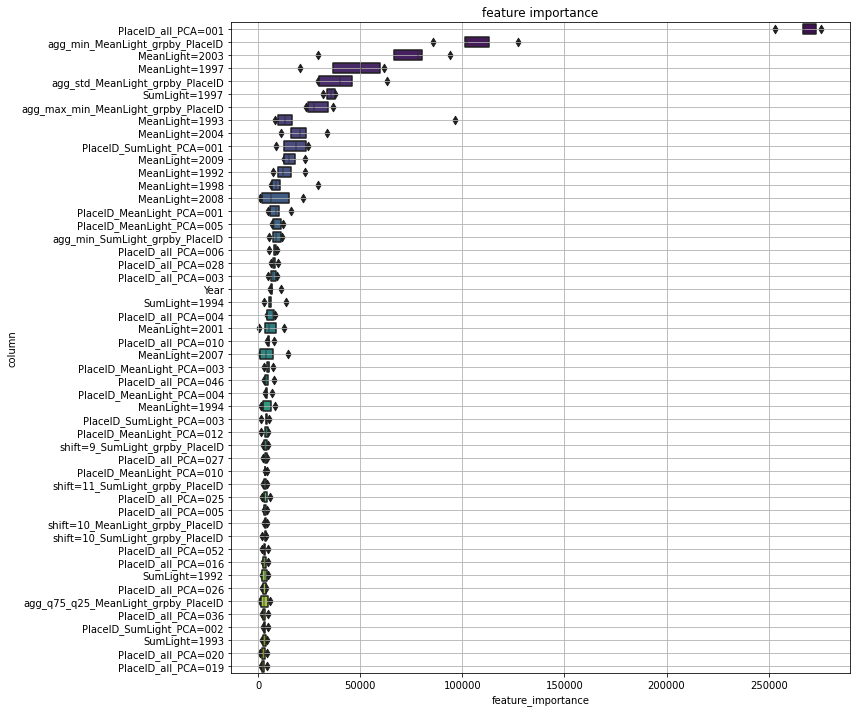

In [16]:
def tree_importance(X, y, model, model_params, fit_params, cv, folds):
    est = model(**model_params)
    feature_importance_df = pd.DataFrame()
    for i, (tr_idx, va_idx) in enumerate(cv(X, y, n_splits=folds)):
        tr_x, va_x = X.values[tr_idx], X.values[va_idx]
        tr_y, va_y = y.values[tr_idx], y.values[va_idx]
        est.fit(tr_x, tr_y,
                eval_set=[[va_x, va_y]],
                **fit_params) 
        _df = pd.DataFrame()
        _df['feature_importance'] = est.feature_importances_
        _df['column'] = X.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)
    order = feature_importance_df.groupby('column') \
                .sum()[['feature_importance']] \
                .sort_values('feature_importance', ascending=False).index[:50]
    fig, ax = plt.subplots(figsize=(12, max(4, len(order) * .2)))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', order=order, ax=ax,
                  palette='viridis')
    fig.tight_layout()
    ax.grid()
    ax.set_title('feature importance')
    fig.tight_layout()
    plt.show()
    return fig, feature_importance_df
    
fig, _ = tree_importance(train_x, train_y, model, model_params, fit_params, cv=make_gkf, folds=5)

In [17]:
def predict_cv(X, y, model, model_params, fit_params, cv, folds, seeds, metrics, name=""):
    oof_seeds = []; scores_seeds = []; models = {}
    for seed in seeds:
        oof = []; va_idxes = []; scores = []
        train_x, train_y = X.values, y.values
        fold_idx = cv(train_x, train_y, n_splits=folds, random_state=seed) 
        if "random_state" in model_params:
            model_params["random_state"] = seed
            
        # train and predict by cv folds
        for cv_num, (tr_idx, va_idx) in enumerate(fold_idx):
            tr_x, va_x = train_x[tr_idx], train_x[va_idx]
            tr_y, va_y = train_y[tr_idx], train_y[va_idx]
            va_idxes.append(va_idx)
            est = model(**model_params)

            # fitting - train
            est.fit(tr_x, tr_y,
                    eval_set=[[va_x, va_y]],
                    **fit_params) 
            model_name = f"{name}_SEED{seed}_FOLD{cv_num}_model"
            models[model_name] = est  # save model

            # predict - validation
            pred = est.predict(va_x)
            oof.append(pred)

            # validation score
            score = metrics(va_y, pred)
            scores.append(score)
            print(f"SEED:{seed}, FOLD:{cv_num} >>>> val_score:{score:.4f}")

        # sort as default
        va_idxes = np.concatenate(va_idxes)
        oof = np.concatenate(oof)
        order = np.argsort(va_idxes)
        oof = oof[order]
        oof_seeds.append(oof)
        scores_seeds.append(np.mean(scores))

    oof = np.mean(oof_seeds, axis=0)
    print(f"model:{name} score:{metrics(train_y, oof):.4f}\n")
    return oof, models
    
# oof予測値と学習済みモデルをGet!
oof, models = predict_cv(train_x, train_y, model,  # 説明変数, 目的変数, モデル
                         model_params,  # モデルパラメータ 
                         fit_params,  # fit時のパラメータ
                         cv=make_gkf,  # cv strategy 
                         folds=5,   # num folds
                         seeds=[0, 1, 2], # 3 seed average
                         metrics=root_mean_squared_error,  # 評価関数
                         name="lgbm"
                        )		

SEED:0, FOLD:0 >>>> val_score:0.5396
SEED:0, FOLD:1 >>>> val_score:0.5393
SEED:0, FOLD:2 >>>> val_score:0.5796
SEED:0, FOLD:3 >>>> val_score:0.5196
SEED:0, FOLD:4 >>>> val_score:0.5375
SEED:1, FOLD:0 >>>> val_score:0.5270
SEED:1, FOLD:1 >>>> val_score:0.5426
SEED:1, FOLD:2 >>>> val_score:0.5162
SEED:1, FOLD:3 >>>> val_score:0.5470
SEED:1, FOLD:4 >>>> val_score:0.5375
SEED:2, FOLD:0 >>>> val_score:0.5495
SEED:2, FOLD:1 >>>> val_score:0.5442
SEED:2, FOLD:2 >>>> val_score:0.5494
SEED:2, FOLD:3 >>>> val_score:0.5321
SEED:2, FOLD:4 >>>> val_score:0.5511
model:lgbm score:0.5341



In [18]:
def predict_test(test_x, models):
    preds = []
    for name, est in models.items():
        print(f"{name} >>>> ")
        _pred = est.predict(test_x)
        preds.append(_pred)
    preds = np.mean(preds, axis=0)
    return preds
    
# 提出用の予測値をGet!
preds = predict_test(test_x, models)

lgbm_SEED0_FOLD0_model >>>> 
lgbm_SEED0_FOLD1_model >>>> 
lgbm_SEED0_FOLD2_model >>>> 
lgbm_SEED0_FOLD3_model >>>> 
lgbm_SEED0_FOLD4_model >>>> 
lgbm_SEED1_FOLD0_model >>>> 
lgbm_SEED1_FOLD1_model >>>> 
lgbm_SEED1_FOLD2_model >>>> 
lgbm_SEED1_FOLD3_model >>>> 
lgbm_SEED1_FOLD4_model >>>> 
lgbm_SEED2_FOLD0_model >>>> 
lgbm_SEED2_FOLD1_model >>>> 
lgbm_SEED2_FOLD2_model >>>> 
lgbm_SEED2_FOLD3_model >>>> 
lgbm_SEED2_FOLD4_model >>>> 


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

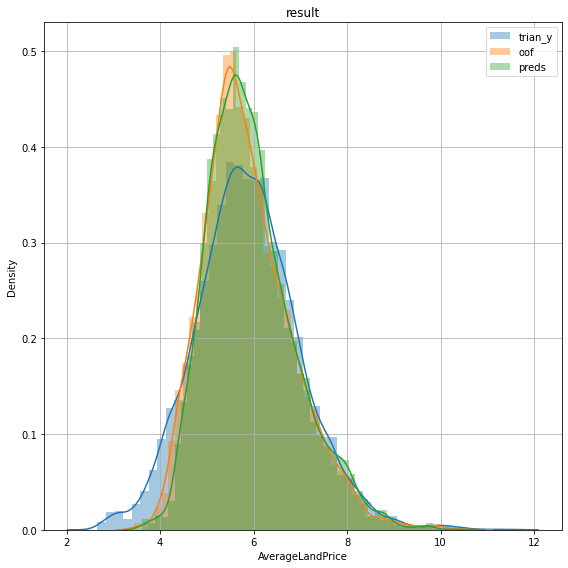

In [19]:
def result_plot(train_y, oof, preds):
    name = "result"
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.distplot(train_y, label='trian_y')
    sns.distplot(oof, label='oof')
    sns.distplot(preds, label='preds')
    ax.legend()
    ax.grid()
    ax.set_title(name)
    fig.tight_layout()
    plt.show()

result_plot(train_y, oof, preds)

In [22]:
submission["LandPrice"] = np.expm1(preds)  # RMSE → RMSLE
submission.to_csv(os.path.join(OUTPUT_DIR, 'sub_'+NB_NAME+'.csv'), index=False)